In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

train_df = pd.read_csv('training_data.csv')
test_df = pd.read_csv('testing_data.csv')

features = [
    'Receiver_Score', 'offense_composite', 'defense_composite',
    'opponent_defensive_score', 'adjusted_receiver_score'
]

train_df['Top_50'] = (train_df['Receiver_Rank'] <= 50).astype(int)
test_df['Top_50'] = (test_df['Receiver_Rank'] <= 50).astype(int)

X_train = train_df[features]
y_train = train_df['Top_50']
X_test = test_df[features]
y_test = test_df['Top_50']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

y_pred = model.predict(X_test).flatten()

aggregated_test_df = test_df.groupby('wide_receiver').agg({
    'Receiver_Score': 'mean',
    'offense_composite': 'mean',
    'defense_composite': 'mean',
    'opponent_defensive_score': 'mean',
    'adjusted_receiver_score': 'mean',
    'Receiver_Rank': 'mean'
}).reset_index()

aggregated_test_df['Games_Played'] = test_df.groupby('wide_receiver').size().values


X_aggregated_test = scaler.transform(aggregated_test_df[features])
aggregated_test_df['Predicted_Rank'] = model.predict(X_aggregated_test).flatten()

final_rankings = aggregated_test_df.sort_values(by='Predicted_Rank', ascending=False)
final_rankings['Final_Rank'] = range(1, len(final_rankings) + 1) 

Epoch 1/50


C:\Users\jacob\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9059 - loss: 0.4368 - val_accuracy: 0.9466 - val_loss: 0.1339
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9559 - loss: 0.1325 - val_accuracy: 0.9838 - val_loss: 0.0584
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9835 - loss: 0.0670 - val_accuracy: 0.9903 - val_loss: 0.0357
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9820 - loss: 0.0457 - val_accuracy: 0.9903 - val_loss: 0.0300
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9871 - loss: 0.0341 - val_accuracy: 0.9919 - val_loss: 0.0261
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9905 - loss: 0.0280 - val_accuracy: 0.9871 - val_loss: 0.0287
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9906 - loss: 0.0243 - val_accuracy: 0.9871 - val_loss: 0.0280
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9882 - loss: 0.0286 - val_accuracy: 0.9871 - val_loss: 0.0239
Epo

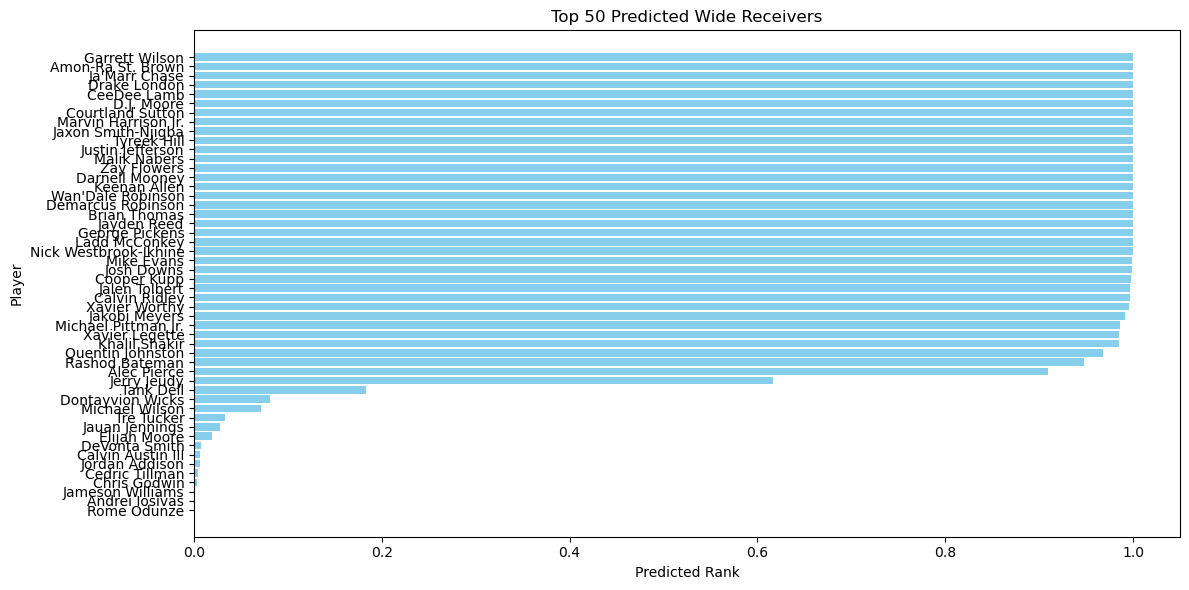

In [4]:
top_50 = final_rankings.head(50)
plt.figure(figsize=(12, 6))
plt.barh(top_50['wide_receiver'], top_50['Predicted_Rank'], color='skyblue')
plt.xlabel('Predicted Rank')
plt.ylabel('Player')
plt.title('Top 50 Predicted Wide Receivers')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [5]:
print(top_50[['Final_Rank', 'wide_receiver', 'Predicted_Rank', 'Games_Played']])

     Final_Rank          wide_receiver  Predicted_Rank  Games_Played
162           1         Garrett Wilson        1.000000            11
19            2      Amon-Ra St. Brown        1.000000            10
190           3          Ja'Marr Chase        1.000000            10
142           4           Drake London        1.000000            10
71            5            CeeDee Lamb        1.000000             9
99            6             D.J. Moore        1.000000             9
93            7       Courtland Sutton        0.999999            11
333           8    Marvin Harrison Jr.        0.999997            10
233           9     Jaxon Smith-Njigba        0.999996            11
461          10            Tyreek Hill        0.999996            10
281          11       Justin Jefferson        0.999993            10
326          12           Malik Nabers        0.999986             9
485          13            Zay Flowers        0.999982            10
113          14         Darnell Mo

In [39]:
print("Available weeks in train_df:", train_df['week'].unique())

# Define specific weeks for the validation set
validation_weeks = ["Week11", "Week12","Week10"]  # Example weeks

# Ensure that the weeks exist in the data
if not set(validation_weeks).intersection(train_df['week'].unique()):
    raise ValueError(f"No data found for the specified validation weeks: {validation_weeks}")

# Split the training data into training and validation sets
validation_df = train_df[train_df['week'].isin(validation_weeks)]
train_subset_df = train_df[~train_df['week'].isin(validation_weeks)]

# Check the sizes of the resulting datasets
print(f"Training data size: {train_subset_df.shape}")
print(f"Validation data size: {validation_df.shape}")

# Features and labels for training and validation
X_train_subset = train_subset_df[features]
y_train_subset = train_subset_df['Top_50']
X_val = validation_df[features]
y_val = validation_df['Top_50']

# Ensure that the datasets are not empty
if X_train_subset.empty or X_val.empty:
    raise ValueError("One of the datasets (training or validation) is empty. Check your week filtering.")

# Standardize the data
scaler = StandardScaler()
X_train_subset = scaler.fit_transform(X_train_subset)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Proceed with model training and evaluation
model = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_subset, y_train_subset,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

Available weeks in train_df: ['Week10' 'Week14' 'Week15' 'Week13' 'Week12' 'Week1' 'Week11']
Training data size: (1868, 14)
Validation data size: (1219, 14)
Epoch 1/5


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8887 - loss: 0.4641 - val_accuracy: 0.9253 - val_loss: 0.1844
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9270 - loss: 0.1818 - val_accuracy: 0.9680 - val_loss: 0.0882
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9703 - loss: 0.0874 - val_accuracy: 0.9877 - val_loss: 0.0505
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9847 - loss: 0.0578 - val_accuracy: 0.9885 - val_loss: 0.0380
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0397 - val_accuracy: 0.9910 - val_loss: 0.0293
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.0874 - loss: 3346.0803  
Test Accuracy: 0.07498042285442352


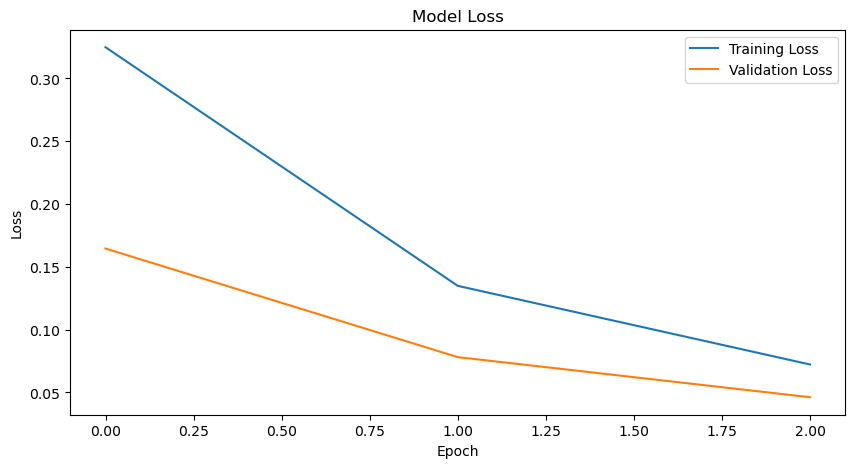

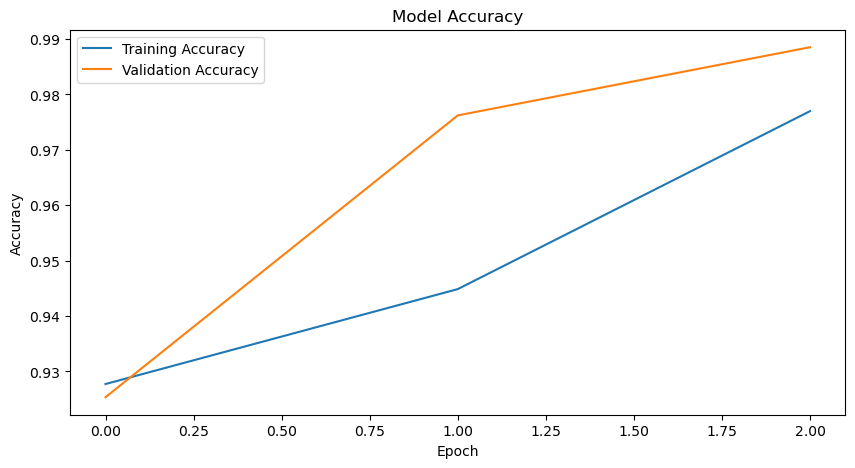

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 1. Plot Training and Validation Metrics
def plot_training_history(history):
    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)


In [31]:
y_test_pred = (y_pred > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4754
           1       0.99      0.96      0.97       354

    accuracy                           1.00      5108
   macro avg       0.99      0.98      0.99      5108
weighted avg       1.00      1.00      1.00      5108



In [41]:

print("\nFinal Rankings:")
print(final_rankings[['wide_receiver', 'Final_Rank', 'Predicted_Rank']].head(50).to_string(index=False))



Final Rankings:
        wide_receiver  Final_Rank  Predicted_Rank
       Garrett Wilson           1        1.000000
    Amon-Ra St. Brown           2        1.000000
        Ja'Marr Chase           3        1.000000
         Drake London           4        1.000000
          CeeDee Lamb           5        1.000000
           D.J. Moore           6        1.000000
     Courtland Sutton           7        0.999999
  Marvin Harrison Jr.           8        0.999997
   Jaxon Smith-Njigba           9        0.999996
          Tyreek Hill          10        0.999996
     Justin Jefferson          11        0.999993
         Malik Nabers          12        0.999986
          Zay Flowers          13        0.999982
       Darnell Mooney          14        0.999966
         Keenan Allen          15        0.999936
    Wan'Dale Robinson          16        0.999934
    Demarcus Robinson          17        0.999920
         Brian Thomas          18        0.999857
          Jayden Reed          19

In [23]:
final_rankings.to_csv('final_receiver_rankings.csv', index=False)
print("Final rankings saved to final_receiver_rankings.csv")

Final rankings saved to final_receiver_rankings.csv
